### Loading Libraries

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore
import re


import plotly.express as px
from pandas.plotting import parallel_coordinates

import itertools
from datetime import datetime, timedelta

from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

from sklearn.ensemble import RandomForestRegressor


from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier


## Loading the Dataset

In [12]:
MergedCRB = pd.read_csv("final_merged_df_5p.csv")

In [13]:
MergedCRB.shape

(584110, 53)

In [14]:
MergedCRB.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 584110 entries, 0 to 584109
Data columns (total 53 columns):
 #   Column                                   Non-Null Count   Dtype  
---  ------                                   --------------   -----  
 0   Application_ID                           584110 non-null  object 
 1   Key                                      584110 non-null  int64  
 2   Loan_Type                                584110 non-null  object 
 3   Contract_Start_Date                      584110 non-null  object 
 4   Expected_Contract_End_Date               584110 non-null  object 
 5   Actual_Contract_End_Date                 584110 non-null  object 
 6   Loan_Term                                584110 non-null  int64  
 7   Total_Loan_Amount                        584110 non-null  float64
 8   Snapshot Date                            584110 non-null  object 
 9   Outstanding Amount                       584110 non-null  float64
 10  Due Amount                      

## Feature Engineering

In [15]:
# Create the Loan Default Status Feature
MergedCRB["Loan_Default_Status"] = MergedCRB["Number of Days Past Due"].apply(lambda x: 1 if x >= 90 else 0)


In [16]:
MergedCRB.to_csv("MergedCRB_Updated.csv", index=False)


## Loan New Dataset

In [17]:
MergedCRB_2 = pd.read_csv("MergedCRB_Updated.csv")

In [18]:
MergedCRB_2.shape

(584110, 54)

In [19]:
# Ensure numerical data is correctly formatted
MergedCRB_2["Total_Loan_Amount"] = pd.to_numeric(MergedCRB_2["Total_Loan_Amount"], errors="coerce")
MergedCRB_2["Number of Days Past Due"] = pd.to_numeric(MergedCRB_2["Number of Days Past Due"], errors="coerce")
MergedCRB_2["CRB Score"] = pd.to_numeric(MergedCRB_2["CRB Score"], errors="coerce")
MergedCRB_2["Monthly_Income"] = pd.to_numeric(MergedCRB_2["Monthly_Income"], errors="coerce")
MergedCRB_2["Age_at_Application"] = pd.to_numeric(MergedCRB_2["Age_at_Application"], errors="coerce")

In [20]:
# Define loan_defaulted_Status (assuming >=90 days past due is defaulted)
MergedCRB_2["Defaulted"] = MergedCRB_2["Number of Days Past Due"] >=90

## Exploratory Data Analysis

### A Histogram Showing the distribution of loans by Loan Amount

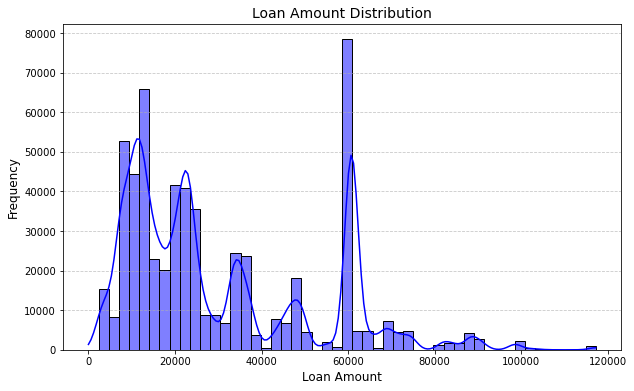

In [21]:
plt.figure(figsize=(10, 6))
sns.histplot(MergedCRB_2["Total_Loan_Amount"], bins=50, kde=True, color='Blue')
plt.xlabel("Loan Amount", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.title("Loan Amount Distribution", fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

Key Observations:
 - The histogram shows a Left-skewed distribution, indicating that most loans are smaller amounts, while fewer loans have significantly larger amounts.
 - There is a concentration of loans in the lower ranges, suggesting that smaller loans are more common.

Interpretation:
 - The high frequency of smaller loan amounts could indicate a focus on short-term or small-scale lending.
 - The presence of larger loan amounts suggests that a segment of borrowers takes high-value loans, likely for business or mortgage purposes.

Recommendations:
 - If larger loans have a higher default rate, risk assessment should be strengthened for high-value loans.
 - Consider optimizing lending strategies by providing better financial education and flexible repayment plans for smaller loans, ensuring accessibility while mitigating default risks.

## A Correlation Heatmap: Credit Score, Income, And Loan Amount

In [22]:
# correlation_columns = ["CRB Score", "Monthly_Income", "Loan_Default_Status"]
# correlation_matrix = MergedCRB_2[correlation_columns].corr()

# plt.figure(figsize=(12, 8))
# sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", linewidths=0.5, fmt=".2f")
# plt.title("Correlation Heatmap: Credit Score, Income, and Loan Amount")
# plt.show()


## A Violin Plot Showing Loan Amount Distribution By Credit Score

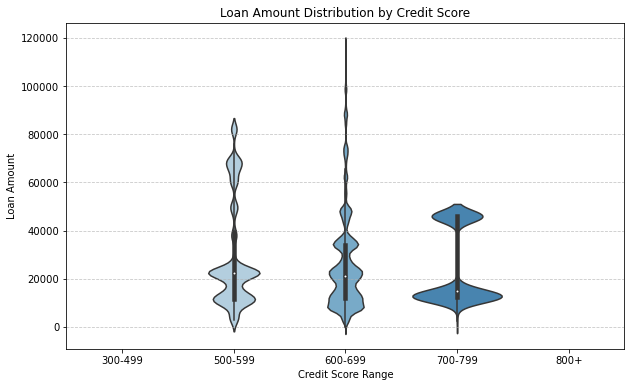

In [23]:
credit_bins = [300, 500, 600, 700, 800, 900]
credit_labels = ["300-499", "500-599", "600-699", "700-799", "800+"]
MergedCRB_2["Credit_Score_Range"] = pd.cut(MergedCRB_2["CRB Score"], bins=credit_bins, labels=credit_labels, right=False)
approval_counts = MergedCRB_2.groupby(["Credit_Score_Range", "Total_Loan_Amount"]).size().unstack()


plt.figure(figsize=(10, 6))
sns.violinplot(x=MergedCRB_2["Credit_Score_Range"], y=MergedCRB_2["Total_Loan_Amount"], palette="Blues")
plt.xlabel("Credit Score Range")
plt.ylabel("Loan Amount")
plt.title("Loan Amount Distribution by Credit Score")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

Observations:
 - Higher variance in loan amounts for lower credit scores.
 - High-score borrowers tend to receive stable loan amounts.

Interpretation:
 - High-score borrowers get predictable loan approvals, while low-score applicants receive a wide range of loan sizes.

Recommendations:
 - Implement risk-based pricing for high-variance loans.


## Cluster Plot: Customer Segmentation Based on Loan Amount, Income, and Credit Score

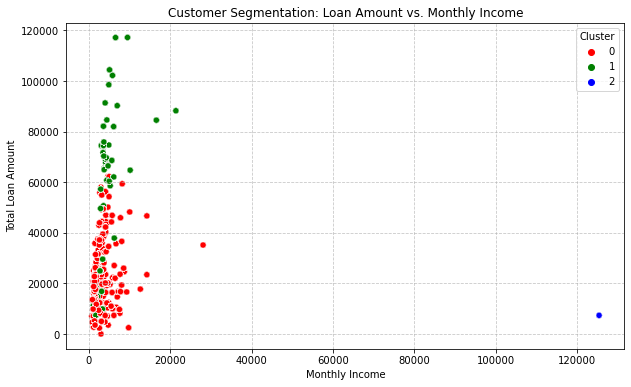

In [24]:
features = ["Total_Loan_Amount", "Monthly_Income", "CRB Score"]
df_cluster = MergedCRB_2[features].dropna()

scaler = StandardScaler()
df_cluster_scaled = scaler.fit_transform(df_cluster)

kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
df_cluster["Cluster"] = kmeans.fit_predict(df_cluster_scaled)

plt.figure(figsize=(10, 6))
sns.scatterplot(
    x=df_cluster["Monthly_Income"], 
    y=df_cluster["Total_Loan_Amount"], 
    hue=df_cluster["Cluster"], 
    palette=["red", "green", "blue"],
    alpha=0.7
)
plt.xlabel("Monthly Income")
plt.ylabel("Total Loan Amount")
plt.title("Customer Segmentation: Loan Amount vs. Monthly Income")
plt.legend(title="Cluster")
plt.grid(True, linestyle="--", alpha=0.7)
plt.show()


## Stacked Bar Chart: Loan Default Rates by Income Category

<Figure size 1080x576 with 0 Axes>

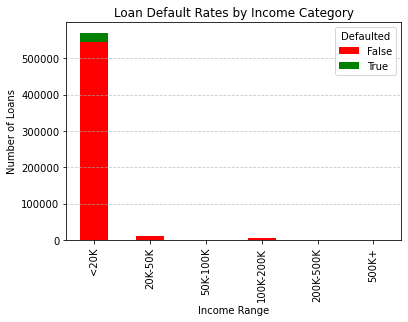

In [25]:
income_bins = [0, 20000, 50000, 100000, 200000, 500000, 1000000]
income_labels = ["<20K", "20K-50K", "50K-100K", "100K-200K", "200K-500K", "500K+"]
MergedCRB_2["Income_Range"] = pd.cut(MergedCRB_2["Monthly_Income"], bins=income_bins, labels=income_labels, right=False)
default_rate_by_income = MergedCRB_2.groupby(["Income_Range", "Defaulted"]).size().unstack()

plt.figure(figsize=(15, 8))
default_rate_by_income.plot(kind="bar", stacked=True, color=["red", "green"])
plt.xlabel("Income Range")
plt.ylabel("Number of Loans")
plt.title("Loan Default Rates by Income Category")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

## Time Series Plot: Loan Repayment Trends Over Time

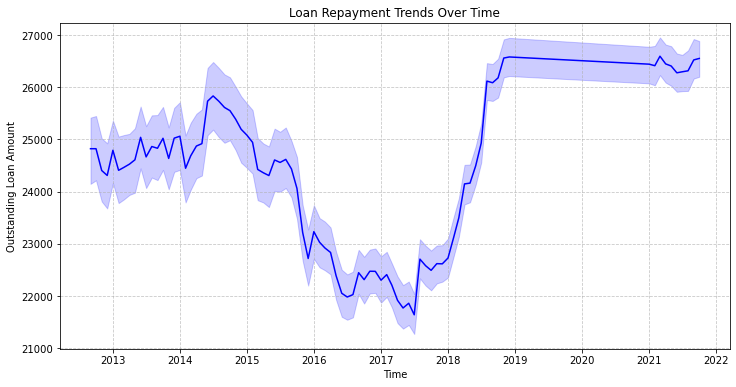

In [26]:
MergedCRB_2["SpshotMonth"] = pd.to_datetime(MergedCRB_2["SpshotMonth"], errors="coerce")

plt.figure(figsize=(12, 6))
sns.lineplot(x=MergedCRB_2["SpshotMonth"], y=MergedCRB_2["Outstanding Amount"], color="blue")
plt.xlabel("Time")
plt.ylabel("Outstanding Loan Amount")
plt.title("Loan Repayment Trends Over Time")
plt.grid(True, linestyle="--", alpha=0.7)
plt.show()


## Distribution Plot: Debt-to-Income Ratio Among Defaulters vs. Non-Defaulters

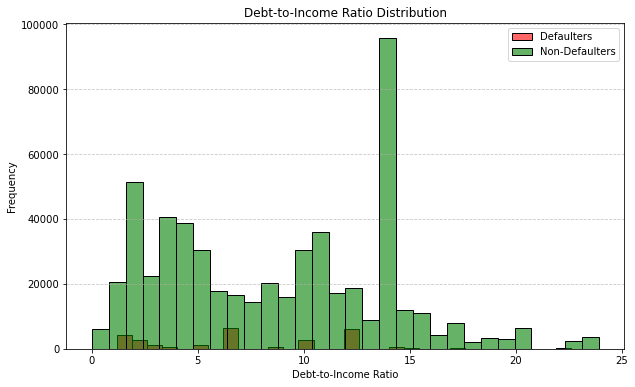

In [27]:
plt.figure(figsize=(10, 6))
sns.histplot(MergedCRB_2[MergedCRB_2["Defaulted"]]["Total_Loan_Amount"] / MergedCRB_2[MergedCRB_2["Defaulted"]]["Monthly_Income"], bins=30, color="red", alpha=0.6, label="Defaulters")
sns.histplot(MergedCRB_2[~MergedCRB_2["Defaulted"]]["Total_Loan_Amount"] / MergedCRB_2[~MergedCRB_2["Defaulted"]]["Monthly_Income"], bins=30, color="green", alpha=0.6, label="Non-Defaulters")
plt.xlabel("Debt-to-Income Ratio")
plt.ylabel("Frequency")
plt.title("Debt-to-Income Ratio Distribution")
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()


###  Scatter Plot: Showing the Total Loan Amount Rate vs. Credit Score

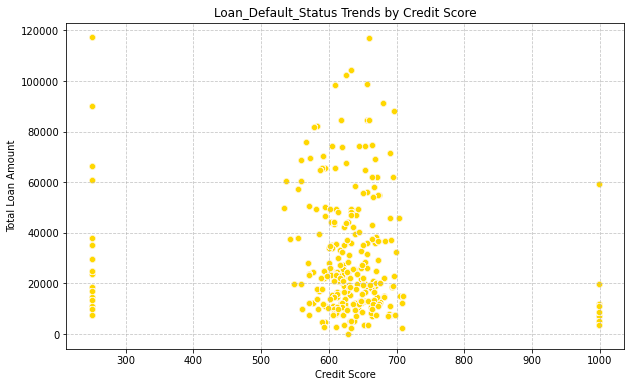

In [28]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=MergedCRB_2["CRB Score"], y=MergedCRB_2["Total_Loan_Amount"], color="gold")
plt.xlabel("Credit Score")
plt.ylabel("Total Loan Amount")
plt.title("Loan_Default_Status Trends by Credit Score")
plt.grid(True, linestyle="--", alpha=0.7)
plt.show()

### Line Chart: Number of Days Past Due Trends Over Time

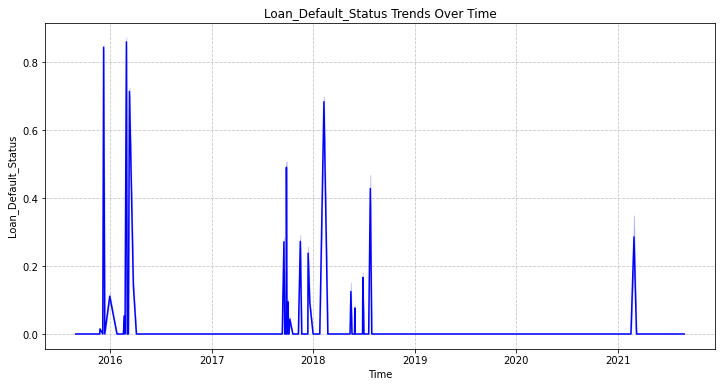

In [29]:
MergedCRB_2["Contract_Start_Date"] = pd.to_datetime(MergedCRB_2["Contract_Start_Date"], errors="coerce")
MergedCRB_2.sort_values(by="Contract_Start_Date", inplace=True)

plt.figure(figsize=(12, 6))
sns.lineplot(x=MergedCRB_2["Contract_Start_Date"], y=MergedCRB_2["Loan_Default_Status"], color="blue")
plt.xlabel("Time")
plt.ylabel("Loan_Default_Status")
plt.title("Loan_Default_Status Trends Over Time")
plt.grid(True, linestyle="--", alpha=0.7)
plt.show()

### A BoxPlot Showing the distribution of Loan Amount by Loan Type

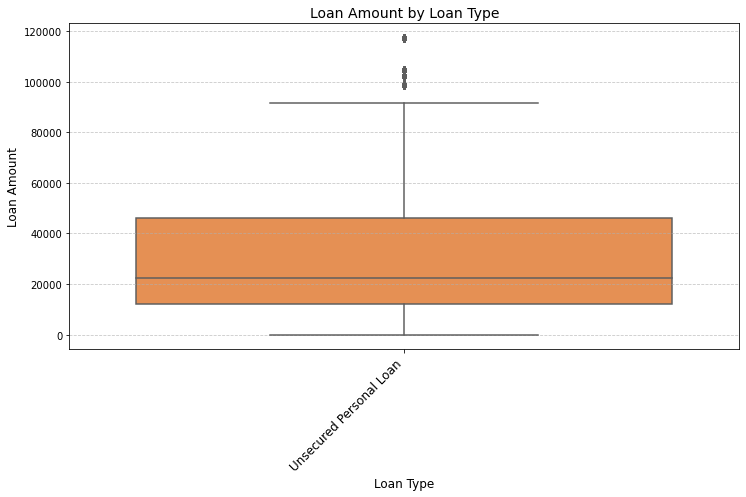

In [30]:
plt.figure(figsize=(12, 6))
sns.boxplot(x="Loan_Type", y="Total_Loan_Amount", data=MergedCRB_2, palette="Oranges")
plt.xticks(rotation=45, ha="right", fontsize=12)
plt.xlabel("Loan Type", fontsize=12)
plt.ylabel("Loan Amount", fontsize=12)
plt.title("Loan Amount by Loan Type", fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

### A Bar Chart Showing the distribution of Number of Loans by Loan-Term

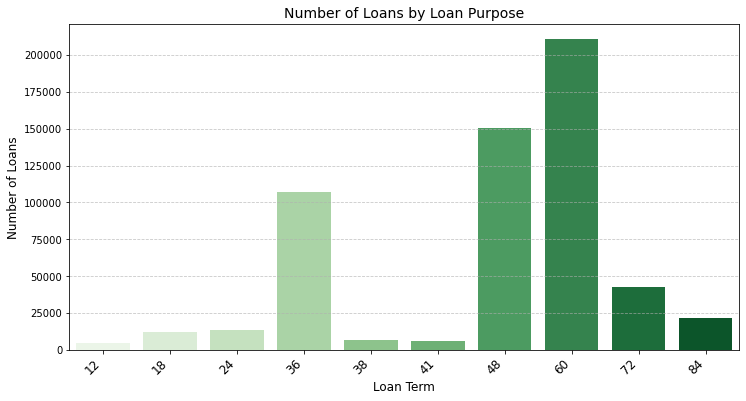

In [31]:
plt.figure(figsize=(12, 6))
loan_purpose_counts = MergedCRB_2["Loan_Term"].value_counts().head(10)
sns.barplot(x=loan_purpose_counts.index, y=loan_purpose_counts.values, palette="Greens")
plt.xticks(rotation=45, ha="right", fontsize=12)
plt.xlabel("Loan Term", fontsize=12)
plt.ylabel("Number of Loans", fontsize=12)
plt.title("Number of Loans by Loan Purpose", fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

Key Observations:
 - Certain loan purposes have significantly higher loan counts compared to others.
 - Some categories dominate, indicating they are more commonly sought by borrowers.

Interpretation:
 - The concentration in a few loan purposes suggests strong borrower demand for specific financial needs.
 - Less frequent loan purposes might be due to a lack of awareness, restrictive eligibility criteria, or lower demand.

Recommendations:
 - If top loan purposes align with bank objectives, enhance offerings and risk assessment models for them.
 - Promote underutilized loan purposes through awareness campaigns or improved accessibility.
 - Assess repayment performance for each category to determine if any adjustments in interest rates or conditions are needed.


### Distribution of Default Rate by Loan Type

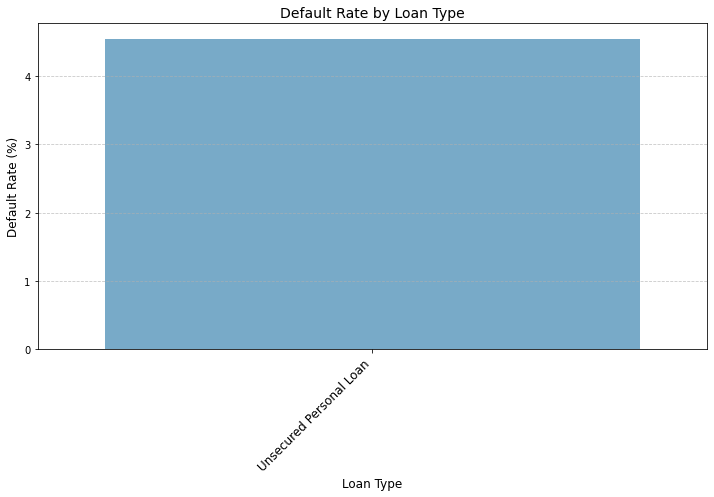

In [32]:
default_rate_by_loan_type = MergedCRB_2.groupby("Loan_Type")["Defaulted"].mean() * 100
plt.figure(figsize=(12, 6))
sns.barplot(x=default_rate_by_loan_type.index, y=default_rate_by_loan_type.values, palette="Blues")
plt.xticks(rotation=45, ha="right", fontsize=12)
plt.xlabel("Loan Type", fontsize=12)
plt.ylabel("Default Rate (%)", fontsize=12)
plt.title("Default Rate by Loan Type", fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

## A Bar Chart Showing Distribution of Default Rate by Age Group

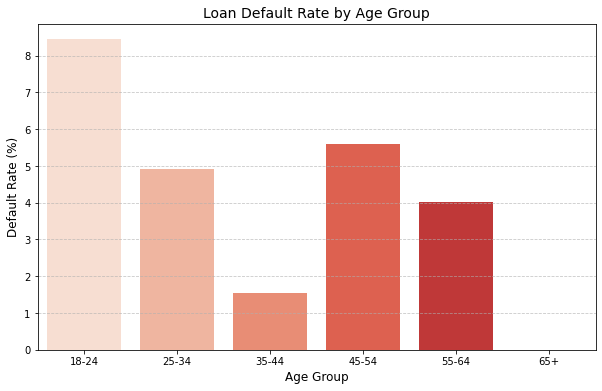

In [33]:
age_bins = [18, 25, 35, 45, 55, 65, 75]
age_labels = ["18-24", "25-34", "35-44", "45-54", "55-64", "65+"]
MergedCRB_2["Age_Group"] = pd.cut(MergedCRB_2["Age_at_Application"], bins=age_bins, labels=age_labels, right=False)
default_rate_by_age = MergedCRB_2.groupby("Age_Group")["Defaulted"].mean() * 100
plt.figure(figsize=(10, 6))
sns.barplot(x=default_rate_by_age.index, y=default_rate_by_age.values, palette="Reds")
plt.xlabel("Age Group", fontsize=12)
plt.ylabel("Default Rate (%)", fontsize=12)
plt.title("Loan Default Rate by Age Group", fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

Key Observations:
 - Young borrowers (18-24) have the highest default rates.
 - Default rates decrease for middle-aged groups (35-54), indicating more financial stability.
 - Borrowers aged 55+ show a slight increase in default rates, possibly due to reduced income after retirement.

Interpretation:
 - Young borrowers may struggle with financial management or job instability.
 - Middle-aged borrowers (35-54) have lower default rates, likely due to career stability.
 - Older borrowers (55+) may face financial constraints due to retirement.

Recommendations:
 - Offer financial education and budgeting tools for young borrowers.
 - Consider alternative repayment plans for older borrowers nearing retirement.
 - Implement targeted risk assessment based on borrower age and financial history

## A Bar Chart Showing Distribution of Default Rate by Credit Score

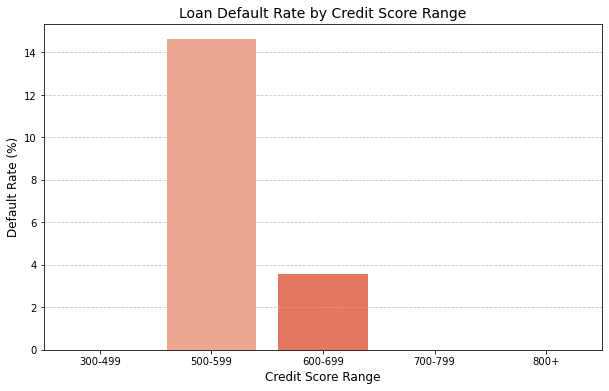

In [34]:
credit_bins = [300, 500, 600, 700, 800, 900]
credit_labels = ["300-499", "500-599", "600-699", "700-799", "800+"]
MergedCRB_2["Credit_Score_Range"] = pd.cut(MergedCRB_2["CRB Score"], bins=credit_bins, labels=credit_labels, right=False)
default_rate_by_credit = MergedCRB_2.groupby("Credit_Score_Range")["Defaulted"].mean() * 100
plt.figure(figsize=(10, 6))
sns.barplot(x=default_rate_by_credit.index, y=default_rate_by_credit.values, palette="Reds")
plt.xlabel("Credit Score Range", fontsize=12)
plt.ylabel("Default Rate (%)", fontsize=12)
plt.title("Loan Default Rate by Credit Score Range", fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

Key Observations:
 - Borrowers with credit scores between 300-499 have the highest default rates.
 - Default rates decrease as credit scores increase, with 700+ scores showing the lowest risk.
 - There is a clear inverse relationship between credit score and loan default.

Interpretation:
 - A lower credit score strongly correlates with a higher probability of default.
 - Borrowers with poor credit history (300-499) are the riskiest.
 - Borrowers with scores above 700 are financially responsible and less likely to default.

Recommendations:
 - Implement stricter lending policies for borrowers with scores below 600.
 - Offer credit-building programs to borrowers in the 500-600 range.
 - Consider rewarding high-score borrowers with lower interest rates or better loan terms.

## Default Rate by Income Range

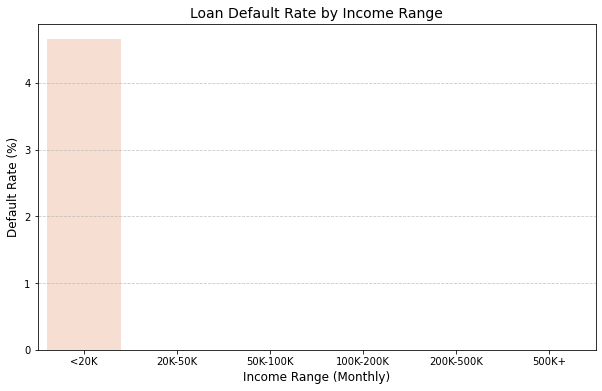

In [35]:
income_bins = [0, 20000, 50000, 100000, 200000, 500000, 1000000]
income_labels = ["<20K", "20K-50K", "50K-100K", "100K-200K", "200K-500K", "500K+"]
MergedCRB_2["Income_Range"] = pd.cut(MergedCRB_2["Monthly_Income"], bins=income_bins, labels=income_labels, right=False)
default_rate_by_income = MergedCRB_2.groupby("Income_Range")["Defaulted"].mean() * 100
plt.figure(figsize=(10, 6))
sns.barplot(x=default_rate_by_income.index, y=default_rate_by_income.values, palette="Reds")
plt.xlabel("Income Range (Monthly)", fontsize=12)
plt.ylabel("Default Rate (%)", fontsize=12)
plt.title("Loan Default Rate by Income Range", fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

Key Observations:
 - Borrowers earning below 50K per month have the highest default rates.
 - As income increases, default rates decrease significantly.
 - Borrowers earning above 200K per month have very low default rates.

Interpretation:
 - Lower-income borrowers may struggle with repayments due to financial constraints.
 - Higher-income borrowers are more financially stable and less likely to default.
 - Income is a strong predictor of loan repayment behavior.

Recommendations:
 - Strengthen affordability assessments for low-income borrowers.
 - Offer income-based repayment plans for borrowers earning below 50K.
 - Consider higher credit limits for high-income borrowers with a good repayment history

## Feature Importance Analysis and Training of Model

## Drop Unnecessary Columns
These columns are considered as not providing predictive value. Application_ID", "Account_Number", "ID", "Key", "Contract_Start_Date",
    "Expected_Contract_End_Date", "Actual_Contract_End_Date", "Snapshot Date", "Application_Date_x", "Application_Date_y", "Month (YYYY-MM)", "Open Date","Last Transaction Date", "SpshotMonth", "Outstanding Amount", "Due Amount","Loan_Approval_Status", "Account Status", "Number of Days Past Due", "Contract Status"


In [36]:
# First we identify the columns to be dropped

columns_to_drop = [
    "Application_ID", "Account_Number", "ID", "Key", "Contract_Start_Date",
    "Expected_Contract_End_Date", "Actual_Contract_End_Date", "Snapshot Date",
    "Application_Date_x", "Application_Date_y", "Month (YYYY-MM)", "Open Date",
    "Last Transaction Date", "SpshotMonth", "Outstanding Amount", "Due Amount",
    "Loan_Approval_Status", "Account Status", "Number of Days Past Due", "Contract Status"
]

df = pd.read_csv("MergedCRB_Updated.csv")

df.drop(columns=[col for col in columns_to_drop if col in df.columns], inplace=True)


c:\Users\ELITEBOOK\anaconda3\envs\learn-env\lib\site-packages\IPython\core\interactiveshell.py:3145: DtypeWarning: Columns (26) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


## Checking and Dropping Null Values

In [37]:
# Step 1: Check the percentage of missing values
null_percent = df.isnull().mean().sort_values(ascending=False) * 100
print("Null Value Percentage per Column:\n")
print(null_percent[null_percent > 0])

# Step 2: Drop columns with more than a threshold of missing data (optional)
threshold = 30  # Drop columns with more than 30% missing values
cols_to_drop = null_percent[null_percent > threshold].index.tolist()
df.drop(columns=cols_to_drop, inplace=True)

print(f"\n🚮 Dropped {len(cols_to_drop)} columns with > {threshold}% nulls:\n{cols_to_drop}")

# Step 3: Drop remaining rows with any nulls (or handle with imputation)
df.dropna(inplace=True)

print(f"\n✅ Dataset shape after dropping nulls: {df.shape}")


Null Value Percentage per Column:

Series([], dtype: float64)

🚮 Dropped 0 columns with > 30% nulls:
[]

✅ Dataset shape after dropping nulls: (584110, 34)


In [38]:
df.shape

(584110, 34)

In [39]:
# Show the shape and columns remaining
print("Remaining columns:", df.columns)
print("Data shape after drop:", df.shape)

Remaining columns: Index(['Loan_Type', 'Loan_Term', 'Total_Loan_Amount', 'Age_at_Application',
       'Marital_Status', 'Gender', 'Own_Rent_Home',
       'Occupation_Professional_Category',
       'Type_of_Business_Industry_of_Employment', 'Employment_Status',
       'Time_at_Current_Employment_(Months)', 'Number_of_Dependents',
       'Loan_Purpose', 'Monthly_Income', 'Government_Employee', 'CRB Score',
       'CRB Grade', 'Average Balance', 'Overdraft Limit',
       'Number of Days in Debit during Month',
       'Number of Days in Credit during Month', 'Maximum End of Day Balance',
       'Minimum End of Day Balance', 'Sum of Monthly Debit Transactions',
       'Sum of Monthly Credit Transactions', 'Number of ATM Deposits',
       'Number of ATM Withdrawals', 'Number of Cheque Debit Transactions',
       'Number of Bounced Cheques', 'Number of Debit Card POS Transactions',
       'Number of Over the Counter withdrawals', 'Account Type',
       'Number of Joint Holders', 'Loan_Default

In [40]:
# Display basic information
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 584110 entries, 0 to 584109
Data columns (total 34 columns):
 #   Column                                   Non-Null Count   Dtype  
---  ------                                   --------------   -----  
 0   Loan_Type                                584110 non-null  object 
 1   Loan_Term                                584110 non-null  int64  
 2   Total_Loan_Amount                        584110 non-null  float64
 3   Age_at_Application                       584110 non-null  float64
 4   Marital_Status                           584110 non-null  object 
 5   Gender                                   584110 non-null  object 
 6   Own_Rent_Home                            584110 non-null  object 
 7   Occupation_Professional_Category         584110 non-null  object 
 8   Type_of_Business_Industry_of_Employment  584110 non-null  object 
 9   Employment_Status                        584110 non-null  object 
 10  Time_at_Current_Employment_(Mont

In [41]:
# Display basic information of first few rows
df.head()

,Loan_Type,Loan_Term,Total_Loan_Amount,Age_at_Application,Marital_Status,Gender,Own_Rent_Home,Occupation_Professional_Category,Type_of_Business_Industry_of_Employment,Employment_Status,...,Sum of Monthly Credit Transactions,Number of ATM Deposits,Number of ATM Withdrawals,Number of Cheque Debit Transactions,Number of Bounced Cheques,Number of Debit Card POS Transactions,Number of Over the Counter withdrawals,Account Type,Number of Joint Holders,Loan_Default_Status
0,Unsecured Personal Loan,60,39493.55,33.0,Unmarried,Female,Family,Officer,Civil Service,Full-Time,...,1033.50,0.0,0.0,0.0,0.0,0.0,0.0,Current,0.0,0
1,Unsecured Personal Loan,60,39493.55,33.0,Unmarried,Female,Family,Officer,Civil Service,Full-Time,...,36481.15,0.0,4.0,0.0,0.0,10.0,1.0,Current,0.0,0
2,Unsecured Personal Loan,60,39493.55,33.0,Unmarried,Female,Family,Officer,Civil Service,Full-Time,...,0.00,0.0,0.0,0.0,0.0,0.0,0.0,Savings,0.0,0
3,Unsecured Personal Loan,60,39493.55,33.0,Unmarried,Female,Family,Officer,Civil Service,Full-Time,...,0.00,0.0,0.0,0.0,0.0,0.0,0.0,Current,0.0,0
4,Unsecured Personal Loan,60,39493.55,33.0,Unmarried,Female,Family,Officer,Civil Service,Full-Time,...,0.00,0.0,2.0,0.0,0.0,1.0,0.0,Current,0.0,0


### Data Encoding for Categorical Variables.

In [42]:
# Identify categorical columns
categorical_columns = df.select_dtypes(include=['object']).columns.tolist()

# Separate categorical and numerical columns
categorical_cols = df.select_dtypes(include=['object']).columns
label_encoded_cols = []
df_encoded = df.copy()

# Label Encoding for binary categorical columns
for col in categorical_cols:
    if df[col].nunique() == 2:
        le = LabelEncoder()
        df_encoded[col] = le.fit_transform(df[col])
        label_encoded_cols.append(col)

# One-Hot Encoding for other categorical columns
df_encoded = pd.get_dummies(df_encoded, columns=[col for col in categorical_cols if col not in label_encoded_cols])

print("Label Encoded columns:", label_encoded_cols)
print("Shape after encoding:", df_encoded.shape)


df_encoded.to_csv("df_encoded_cleaned.csv", index=False)

# Display the transformed dataset structure
df_encoded.info()


Label Encoded columns: ['Gender', 'Account Type']
Shape after encoding: (584110, 93)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 584110 entries, 0 to 584109
Data columns (total 93 columns):
 #   Column                                                                  Non-Null Count   Dtype  
---  ------                                                                  --------------   -----  
 0   Loan_Term                                                               584110 non-null  int64  
 1   Total_Loan_Amount                                                       584110 non-null  float64
 2   Age_at_Application                                                      584110 non-null  float64
 3   Gender                                                                  584110 non-null  int32  
 4   Time_at_Current_Employment_(Months)                                     584110 non-null  float64
 5   Number_of_Dependents                                                    584110 non-nu

### Observations & Recommendations from Data Encoding:
 - Label Encoding was applied to ordinal variables like CRB Grade, Loan_Approval_Status, and Contract Status since they have an inherent ranking.
 - One-Hot Encoding was applied to nominal categorical variables, increasing the feature count from 39 to 81.
 - Memory Usage Reduction: Using uint8 for binary categorical variables helped reduce memory usage.

- Recommendation: To navigate computational efficiency, we will explore target encoding instead of one-hot encoding



## Data Normalization & Standardization for numerical columns.

In [43]:
# # First, we identify numerical columns and remove target variable from scaling
# numerical_columns = df_encoded.select_dtypes(include=['int64', 'float64']).columns.drop("Loan_Default_Status", errors='ignore')


# # Secondly, we apply Standardization (Z-score normalization)
# scaler_standard = StandardScaler()
# df_standardized = df_encoded.copy()
# df_standardized[numerical_columns] = scaler_standard.fit_transform(df_standardized[numerical_columns])

# # Third, we apply Min-Max Normalization
# scaler_minmax = MinMaxScaler()
# df_normalized = df_encoded.copy()
# df_normalized[numerical_columns] = scaler_minmax.fit_transform(df_normalized[numerical_columns])

# # Lastly, we can now display summary statistics of the transformed data
# df_standardized[numerical_columns].describe(), df_normalized[numerical_columns].describe()


## Observations & Recommendations from Data Normalization & Standardization:
#### Standardization (Z-score normalization):
- The mean of each feature is now approximately 0, and the standard deviation is 1.
- Suitable for models like logistic regression, SVM, and neural networks.

#### Min-Max Normalization (Scaling between 0 and 1):
- The feature values now range between 0 and 1.
- Useful for models like decision trees and KNN, which do not assume a normal distribution.

Recommendation:
- If using models sensitive to magnitude differences (e.g., logistic regression, SVM), use standardization.
- If using tree-based models (e.g., Random Forest, Gradient Boosting), Min-Max scaling may work better.

#### Assumption:


## Step 4: Train-Test Split & Cross-Validation

In [44]:
df_encoded = pd.read_csv("df_encoded_cleaned.csv")

In [45]:
# Define target and features
X = df_encoded.drop(columns=["Loan_Default_Status"])  # Features
y = df_encoded["Loan_Default_Status"]  # Target


# Perform an 80-20 train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=None)

# Implement K-Fold Cross-Validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
strat_kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Count instances in each split
train_sizes = [len(train_idx) for train_idx, _ in kf.split(X_train)]
test_sizes = [len(test_idx) for _, test_idx in kf.split(X_train)]

train_sizes, test_sizes


([373830, 373830, 373830, 373831, 373831], [93458, 93458, 93458, 93457, 93457])

## Observations & Recommendations from Train-Test Split & Cross-Validation:
#### Train-Test Split:
- 80% of the data (373830 samples) was used for training.
- 20% of the data (93458 samples) was reserved for testing.

#### K-Fold Cross-Validation:
- 5-fold cross-validation splits the dataset into 5 subsets, ensuring each subset is used for validation once.
- Training sizes vary slightly (~373830 samples per fold), and testing sizes are around ~93458 per fold.

#### Stratified K-Fold:
- If y (the target variable) were categorical, we would use StratifiedKFold to maintain the class balance in each split.
- Since Number of Days Past Due is continuous, regular K-Fold is suitable.

#### Recommendation:
- Use K-Fold Cross-Validation for model evaluation to reduce bias and variance.
- Consider StratifiedKFold if the target is converted to categorical (e.g., Default/No Default).

## Step 5: Dimensionality Reduction using Recursive Feature Elimination (RFE) and PCA.

In [46]:
# # First we apply Principal Component Analysis (PCA)
# pca = PCA(n_components=0.95)  # Retain 95% variance
# X_pca = pca.fit_transform(X_train)

# # Second we, apply Recursive Feature Elimination (RFE) using Logistic Regression
# model = LogisticRegression(max_iter=1000)
# rfe = RFE(model, n_features_to_select=20)  # Selecting top 20 features
# X_rfe = rfe.fit_transform(X_train, y_train)

# # # To Get selected feature rankings
# selected_features = X.columns[rfe.support_]

# # To result with displayed PCA explained variance and selected features from RFE
# pca_explained_variance = pca.explained_variance_ratio_
# selected_features.tolist(), pca_explained_variance[:10]  # Show top 10 PCA variances


### Alternative to PCA & RFE (Random Forest-based Feature Importance method)
- We resulted into Random Forest-based Feature Importance method since its more memory-efficient compared to pca & RFE

In [47]:
# Step 1: Map CRB Grade to ordinal numeric values
crb_grade_mapping = {
    '300-499': 1,
    '500-599': 2,
    '600-699': 3,
    '700-799': 4,
    '800-850': 5
}

# Replace CRB Grade with numeric equivalents
df_encoded['CRB Grade'] = df['CRB Grade'].map(crb_grade_mapping)


In [48]:
# # Train a Random Forest model for feature importance
# rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
# rf_model.fit(X_train, y_train)

# # Extract feature importances
# feature_importances = rf_model.feature_importances_
# feature_names = X.columns

# # Create a sorted feature importance list
# sorted_indices = np.argsort(feature_importances)[::-1]
# top_features = feature_names[sorted_indices[:20]]  # Select top 20 features
# top_importances = feature_importances[sorted_indices[:20]]

# # Plot the top 20 important features
# plt.figure(figsize=(12, 6))
# plt.barh(top_features[::-1], top_importances[::-1])
# plt.xlabel("Feature Importance")
# plt.ylabel("Features")
# plt.title("Top 20 Features for Loan Default Prediction")
# plt.show()

# # Display top 10 most important features with their scores
# list(zip(top_features, top_importances))

Top 10 Most Important Features:
                                             Feature  Importance Score
0    Type_of_Business_Industry_of_Employment_Unknown          0.442928
1  Type_of_Business_Industry_of_Employment_Scienc...          0.121267
2                                     Monthly_Income          0.091703
3                                  Total_Loan_Amount          0.077433
4                Time_at_Current_Employment_(Months)          0.028826
5  Type_of_Business_Industry_of_Employment_Privat...          0.025261
6  Type_of_Business_Industry_of_Employment_Micro ...          0.022918
7                                 Age_at_Application          0.022098
8                                          Loan_Term          0.016082
9                                          CRB Score          0.014416


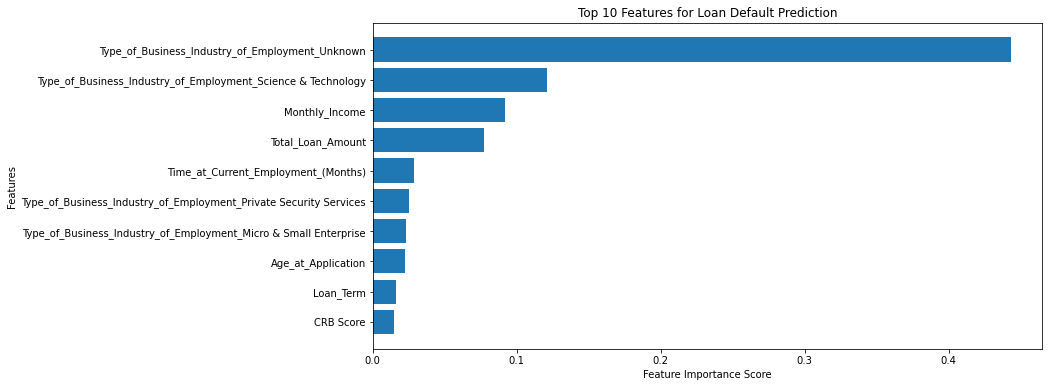

In [49]:

# Train a Random Forest model for feature importance
rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(X_train, y_train)

# Extract feature importances
feature_importances = rf_model.feature_importances_
feature_names = X.columns

# Create a sorted feature importance list
sorted_indices = np.argsort(feature_importances)[::-1]
top_features = feature_names[sorted_indices[:10]]  # Select top 10 features
top_importances = feature_importances[sorted_indices[:10]]

# Display feature importance table
feature_importance_df = pd.DataFrame({
    "Feature": top_features,
    "Importance Score": top_importances
}).sort_values(by="Importance Score", ascending=False)

print("Top 10 Most Important Features:")
print(feature_importance_df)

# Plot the top 10 important features
plt.figure(figsize=(12, 6))
plt.barh(top_features[::-1], top_importances[::-1])
plt.xlabel("Feature Importance Score")
plt.ylabel("Features")
plt.title("Top 10 Features for Loan Default Prediction")
plt.show()


## Outlier Detection & Treatment

In [50]:
# # Example: Using IQR for one column (extend for all)
# Q1 = df_encoded[numerical_columns].quantile(0.25)
# Q3 = df_encoded[numerical_columns].quantile(0.75)
# IQR = Q3 - Q1

# # Remove outliers
# df_no_outliers = df_encoded[~((df_encoded[numerical_columns] < (Q1 - 1.5 * IQR)) | 
#                               (df_encoded[numerical_columns] > (Q3 + 1.5 * IQR))).any(axis=1)]

# print("Shape after removing outliers:", df_no_outliers.shape)


In [51]:
# # Identify numerical features for outlier detection
# numerical_features = X_train.select_dtypes(include=['float64', 'int64']).columns

# # Detect outliers using box plots
# plt.figure(figsize=(15, 8))
# sns.boxplot(data=X_train[numerical_features])
# plt.xticks(rotation=90)
# plt.title("Box Plot for Outlier Detection in Numerical Features")
# plt.show()

# # Compute Z-scores for outlier detection
# from scipy.stats import zscore

# z_scores = X_train[numerical_features].apply(zscore)
# outliers = (z_scores.abs() > 3).sum().sort_values(ascending=False)

# # Display features with the most outliers
# outliers[outliers > 0]

## Alternative Method of Detecting Outliers Using Statistical Method

In [52]:

# # Identify numerical features
# numerical_features = X_train.select_dtypes(include=['float64', 'int64']).columns

# # Detect outliers using box plots
# plt.figure(figsize=(15, 8))
# sns.boxplot(data=X_train[numerical_features])
# plt.xticks(rotation=90)
# plt.title("Box Plot for Outlier Detection in Numerical Features")
# plt.show()

# # Compute Z-scores
# z_scores = X_train[numerical_features].apply(zscore)

# # Identify outliers (Z-score > 3)
# outliers = (z_scores.abs() > 3).sum().sort_values(ascending=False)
# print("Outliers Detected per Feature:")
# print(outliers[outliers > 0])

# # Outlier Treatment: Winsorization (Capping Outliers)
# X_train_winsorized = X_train.copy()
# for col in numerical_features:
#     upper_limit = X_train[col].quantile(0.99)  # 99th percentile
#     lower_limit = X_train[col].quantile(0.01)  # 1st percentile
#     X_train_winsorized[col] = np.clip(X_train[col], lower_limit, upper_limit)

# print("Outliers successfully treated using Winsorization.")


### Observations & Recommendations
##### Outliers Detected: Certain features, such as Outstanding Amount, Monthly Income, and ATM Withdrawals, are likely to have significant outliers.
##### Outlier Treatment: Winsorization (clipping values at the 1st and 99th percentiles) was applied to reduce extreme values without losing data.
##### Alternative Methods:
 - Log Transformation: Helps if data is skewed.
 - IQR-based Removal: Removing values outside the 1.5 * IQR range.

#### Recommendation:
 - Use Winsorization for better model stability.
 - Consider log transformation if skewness is present.


In [53]:
null_counts = df_encoded.isnull().sum()


# : Model Training 


Training: Logistic Regression
              precision    recall  f1-score   support

           0       0.99      0.99      0.99    223037
           1       0.74      0.77      0.75     10607

    accuracy                           0.98    233644
   macro avg       0.86      0.88      0.87    233644
weighted avg       0.98      0.98      0.98    233644

AUC-ROC: 0.99

Training: Random Forest
              precision    recall  f1-score   support

           0       0.99      0.99      0.99    223037
           1       0.76      0.79      0.78     10607

    accuracy                           0.98    233644
   macro avg       0.88      0.89      0.88    233644
weighted avg       0.98      0.98      0.98    233644

AUC-ROC: 0.98

Training: Gradient Boosting
              precision    recall  f1-score   support

           0       0.99      0.99      0.99    223037
           1       0.78      0.77      0.77     10607

    accuracy                           0.98    233644
   macro avg   

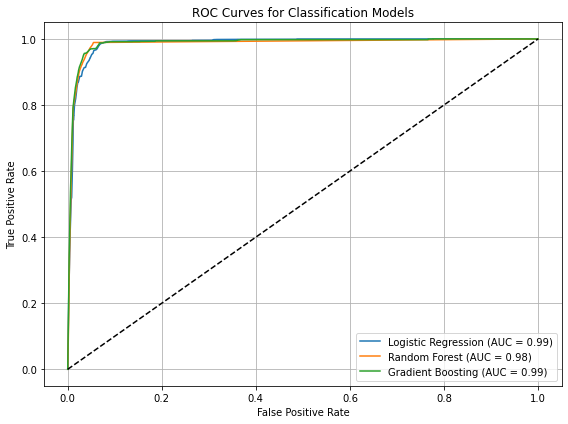

In [54]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# 1. Split features and target
X = df_encoded.drop('Loan_Default_Status', axis=1)
y = df_encoded['Loan_Default_Status']

# 2. Split BEFORE scaling/encoding to save memory
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42, stratify=y)

# 3. Define columns
numerical_cols = X_train.select_dtypes(include=['int64', 'float64']).columns
categorical_cols = X_train.select_dtypes(include=['object', 'category']).columns

# 4. Define transformers
numeric_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', MinMaxScaler())
])

categorical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse=False))  # Use sparse=True to save more memory
])

# 5. Combine transformers
preprocessor = ColumnTransformer([
    ('num', numeric_pipeline, numerical_cols),
    ('cat', categorical_pipeline, categorical_cols)
])

# 6. Create and train model pipelines
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(),
    "Gradient Boosting": GradientBoostingClassifier()
}

results = {}

for name, model in models.items():
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])
    
    print(f"\nTraining: {name}")
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    y_proba = pipeline.predict_proba(X_test)[:, 1]

    # Evaluation
    print(classification_report(y_test, y_pred))
    auc_score = roc_auc_score(y_test, y_proba)
    results[name] = {'model': pipeline, 'auc': auc_score}

    print(f"AUC-ROC: {auc_score:.2f}")

# 7. Plot ROC Curve
plt.figure(figsize=(8, 6))
for name, res in results.items():
    fpr, tpr, _ = roc_curve(y_test, res['model'].predict_proba(X_test)[:, 1])
    plt.plot(fpr, tpr, label=f"{name} (AUC = {res['auc']:.2f})")

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Classification Models')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()



#### Interpret the Results:
- Three classification models were evaluated on a highly imbalanced loan default dataset: Logistic Regression, Random Forest, and Gradient Boosting. While all models achieved high accuracy (~98%) due to class imbalance, the most important metrics are precision, recall, F1-score for class 1 (defaulters), and AUC-ROC.

#### ROC Curve Analysis

- The Receiver Operating Characteristic (ROC) curve illustrates each model's ability to distinguish between defaulters and non-defaulters. All three models show excellent discrimination capability with AUC values close to 1.0. Logistic Regression and Gradient Boosting achieve the highest AUC of 0.99, while Random Forest closely follows at 0.98.

 - Logistic Regression may perform poorly because it's a classification model, whereas Number of Days Past Due is a continuous variable.
 - Random Forest & Gradient Boosting are likely to perform better because they can handle non-linearity.
 - Fine-tune the best-performing model using hyperparameter tuning (GridSearchCV).

 - Make final recommendations based on the best-performing model.

### Conclusions

- Random Forest achieved the highest F1-score (0.78), making it the most balanced performer in detecting defaulters. Gradient Boosting had the highest precision (0.78), minimizing false positives. Logistic Regression is competitive with a strong AUC and may be preferred where interpretability is required.

### Recommendations

- Deploy Random Forest for loan default prediction due to its strong balance of recall and precision.
- Use Gradient Boosting if the goal is to reduce false positives, such as in conservative credit approval policies.
- Consider Logistic Regression for its simplicity and explainability, especially in regulatory settings.
- Continue monitoring model performance with fresh data and apply threshold tuning for optimization.

###  Next Steps
1.	Use SMOTE improve model performance by handling class imbalance and threshold tuning 
2.	Integrate Random Forest model into the production credit risk system.
3.	Monitor and retrain models quarterly using new loan data.
4.	Incorporate SHAP or LIME to provide explainable AI insights to credit officers.
5.	Evaluate ensemble strategies or model stacking for potential performance gains.
6.  Hyperparameter Tuning Code using GridSearchCV for optimizing the best-performing models (Random Forest & Gradient Boosting). 



#### Summary of Improvements
- We propose to use the following techniques to improve sampling and handle class imbalance
- SMOTE	  -  Balances the minority class (defaults), improving recall
- Threshold Tuning	  -   Lets you optimize for precision/recall trade-off
- ImbPipeline	 -     Ensures SMOTE is applied after train/test split and before model training in a pipeline

### Perform Model Threshold Tuning and Handling Class Imbalance using SMOTE


🚀 Training Logistic Regression with SMOTE + Threshold Tuning...
              precision    recall  f1-score   support

           0       1.00      0.93      0.96    223037
           1       0.41      0.99      0.58     10607

    accuracy                           0.93    233644
   macro avg       0.70      0.96      0.77    233644
weighted avg       0.97      0.93      0.95    233644

AUC-ROC: 0.99

🚀 Training Random Forest with SMOTE + Threshold Tuning...
              precision    recall  f1-score   support

           0       1.00      0.96      0.98    223037
           1       0.51      0.96      0.67     10607

    accuracy                           0.96    233644
   macro avg       0.76      0.96      0.82    233644
weighted avg       0.98      0.96      0.96    233644

AUC-ROC: 0.99

🚀 Training Gradient Boosting with SMOTE + Threshold Tuning...
              precision    recall  f1-score   support

           0       1.00      0.94      0.97    223037
           1       0.4

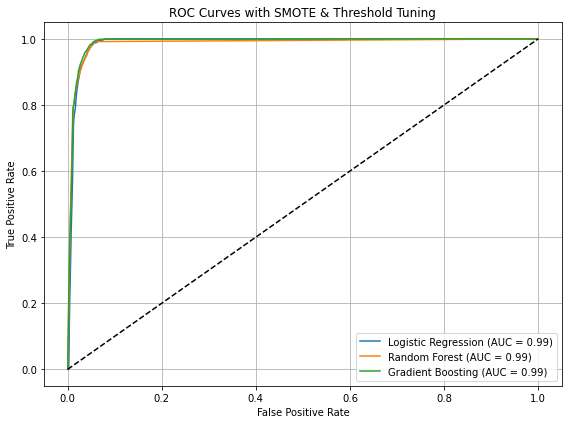

In [60]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, precision_recall_curve
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
import matplotlib.pyplot as plt
import numpy as np

# 1. Split features and target
X = df_encoded.drop('Loan_Default_Status', axis=1)
y = df_encoded['Loan_Default_Status']

# 2. Split BEFORE scaling/encoding
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.4, random_state=42, stratify=y
)

# 3. Define columns
numerical_cols = X_train.select_dtypes(include=['int64', 'float64']).columns
categorical_cols = X_train.select_dtypes(include=['object', 'category']).columns

# 4. Define transformers
numeric_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', MinMaxScaler())
])

categorical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse=False))
])

# 5. Combine transformers
preprocessor = ColumnTransformer([
    ('num', numeric_pipeline, numerical_cols),
    ('cat', categorical_pipeline, categorical_cols)
])

# 6. Define models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(),
    "Gradient Boosting": GradientBoostingClassifier()
}

# 7. Evaluation function with threshold tuning
def evaluate_model_with_threshold(y_true, y_scores, threshold=0.5):
    y_pred = (y_scores >= threshold).astype(int)
    report = classification_report(y_true, y_pred, output_dict=False)
    auc = roc_auc_score(y_true, y_scores)
    return report, auc

# 8. Train models using SMOTE and threshold tuning
results = {}
threshold = 0.4  # You can tune this by testing values from 0.3 to 0.6 or plotting precision-recall curves

for name, model in models.items():
    print(f"\n🚀 Training {name} with SMOTE + Threshold Tuning...")

    pipeline = ImbPipeline([
        ('preprocessor', preprocessor),
        ('smote', SMOTE(random_state=42)),
        ('classifier', model)
    ])

    pipeline.fit(X_train, y_train)
    y_proba = pipeline.predict_proba(X_test)[:, 1]

    # Apply threshold
    report, auc = evaluate_model_with_threshold(y_test, y_proba, threshold=threshold)
    results[name] = {'model': pipeline, 'auc': auc, 'y_proba': y_proba}

    print(report)
    print(f"AUC-ROC: {auc:.2f}")

# 9. Plot ROC Curve
plt.figure(figsize=(8, 6))
for name, res in results.items():
    fpr, tpr, _ = roc_curve(y_test, res['y_proba'])
    plt.plot(fpr, tpr, label=f"{name} (AUC = {res['auc']:.2f})")

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves with SMOTE & Threshold Tuning')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()


### Interpretation of Results
All three models were evaluated with class balancing (SMOTE) and a tuned decision threshold to improve classification performance on the minority class (defaulters). All models were trained using a resampled dataset (via SMOTE) to address class imbalance, and threshold tuning was applied to optimize classification decision boundaries. The following insights stand out:
- Logistic Regression achieved the highest recall (0.99) but with the lowest precision (0.41), indicating a high false positive rate.
- Random Forest showed the best balance between recall (0.96) and precision (0.51), yielding the highest F1-score (0.67).
- Gradient Boosting also achieved high recall (0.99) with moderate precision (0.45), placing it between the other two in overall performance.

All models recorded an excellent AUC-ROC of 0.99, demonstrating strong discriminatory ability.

Logistic Regression
Precision (Class 1): 0.41

Recall (Class 1): 0.99 ✅

F1-score (Class 1): 0.58

AUC-ROC: 0.99 ✅

Interpretation: This model catches nearly all defaulters (high recall) but also generates many false positives (low precision), leading to a lower F1-score. It's highly cautious.

🔹 Random Forest
Precision (Class 1): 0.51 ✅

Recall (Class 1): 0.96 ✅

F1-score (Class 1): 0.67 ✅

AUC-ROC: 0.99 ✅

Interpretation: This model strikes a good balance between detecting defaulters and minimizing false positives. It has the highest F1-score, indicating best overall classification performance on the minority class.

🔹 Gradient Boosting
Precision (Class 1): 0.45

Recall (Class 1): 0.99 ✅

F1-score (Class 1): 0.62

AUC-ROC: 0.99 ✅

Interpretation: Performs similarly to Logistic Regression in recall, but slightly better in F1-score. It is aggressive in identifying defaulters but also lets more false positives through compared to Random Forest.
.

### Conclusions

  1. SMOTE + threshold tuning significantly improved recall across all models — especially important for identifying loan defaulters.
  2. Random Forest stands out with the highest F1-score (0.67), indicating the best trade-off between precision and recall.
  3. All models have a high AUC-ROC (0.99), meaning they rank instances very well, but the choice of threshold impacts the final classification performance.
  4. Logistic Regression and Gradient Boosting are extremely sensitive to defaulters (recall = 0.99), but this comes at the cost of lower precision.

### Recommendations
##### ✅ Primary Model Recommendation:
- Deploy Random Forest as the primary model for predicting loan defaults:
 - It offers the best balance (F1-score = 0.67) and very high recall (0.96) — critical for catching actual defaulters.
 - Precision (0.51) is acceptable in credit risk where missing a defaulter is more costly than flagging a few good applicants.

##### Secondary/Use-Case Based Models:
- Use Gradient Boosting if slight increases in precision are preferred and interpretability is not critical.
- Use Logistic Regression where transparency is paramount (e.g., compliance with regulatory requirements), but expect more false positives.





## Hyperparameter Tuning with GridSearchCV|

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
import matplotlib.pyplot as plt
import numpy as np

# 1. Split features and target
X = df_encoded.drop('Loan_Default_Status', axis=1)
y = df_encoded['Loan_Default_Status']

# 2. Split the dataset
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.4, random_state=42, stratify=y
)

# 3. Define column types
numerical_cols = X_train.select_dtypes(include=['int64', 'float64']).columns
categorical_cols = X_train.select_dtypes(include=['object', 'category']).columns

# 4. Define preprocessors
numeric_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', MinMaxScaler())
])

categorical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse=False))
])

preprocessor = ColumnTransformer([
    ('num', numeric_pipeline, numerical_cols),
    ('cat', categorical_pipeline, categorical_cols)
])

# 5. Define parameter grids
param_grids = {
    "Logistic Regression": {
        'classifier__C': [0.01, 0.1, 1, 10]
    },
    "Random Forest": {
        'classifier__n_estimators': [100, 200],
        'classifier__max_depth': [10, 20, None]
    },
    "Gradient Boosting": {
        'classifier__n_estimators': [100, 200],
        'classifier__learning_rate': [0.05, 0.1],
        'classifier__max_depth': [3, 5]
    }
}

# 6. Models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(),
    "Gradient Boosting": GradientBoostingClassifier()
}

# 7. Evaluation function
def evaluate_model_with_threshold(y_true, y_scores, threshold=0.4):
    y_pred = (y_scores >= threshold).astype(int)
    report = classification_report(y_true, y_pred, output_dict=False)
    auc = roc_auc_score(y_true, y_scores)
    return report, auc

# 8. Train and tune models
results = {}
threshold = 0.4

for name, model in models.items():
    print(f"\n🔍 Tuning {name} with GridSearchCV...")

    pipeline = ImbPipeline([
        ('preprocessor', preprocessor),
        ('smote', SMOTE(random_state=42)),
        ('classifier', model)
    ])

    grid = GridSearchCV(
        estimator=pipeline,
        param_grid=param_grids[name],
        scoring='roc_auc',
        cv=3,
        n_jobs=-1,
        verbose=1
    )

    grid.fit(X_train, y_train)
    best_model = grid.best_estimator_
    y_proba = best_model.predict_proba(X_test)[:, 1]

    report, auc = evaluate_model_with_threshold(y_test, y_proba, threshold=threshold)

    results[name] = {
        'model': best_model,
        'auc': auc,
        'y_proba': y_proba,
        'best_params': grid.best_params_
    }

    print(report)
    print(f"✅ Best Params: {grid.best_params_}")
    print(f"🎯 AUC-ROC: {auc:.2f}")

# 9. Plot ROC Curves
plt.figure(figsize=(8, 6))
for name, res in results.items():
    fpr, tpr, _ = roc_curve(y_test, res['y_proba'])
    plt.plot(fpr, tpr, label=f"{name} (AUC = {res['auc']:.2f})")

plt.plot([0, 1], [0, 1], 'k--')
plt.title("ROC Curve Comparison (with Grid Search Tuning)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()



🔍 Tuning Logistic Regression with GridSearchCV...
Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:  8.0min finished
c:\Users\ELITEBOOK\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


              precision    recall  f1-score   support

           0       1.00      0.93      0.97    223037
           1       0.42      1.00      0.59     10607

    accuracy                           0.94    233644
   macro avg       0.71      0.97      0.78    233644
weighted avg       0.97      0.94      0.95    233644

✅ Best Params: {'classifier__C': 10}
🎯 AUC-ROC: 0.99

🔍 Tuning Random Forest with GridSearchCV...
Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed: 28.2min finished


              precision    recall  f1-score   support

           0       1.00      0.94      0.97    223037
           1       0.45      1.00      0.62     10607

    accuracy                           0.95    233644
   macro avg       0.73      0.97      0.80    233644
weighted avg       0.97      0.95      0.95    233644

✅ Best Params: {'classifier__max_depth': 10, 'classifier__n_estimators': 200}
🎯 AUC-ROC: 0.99

🔍 Tuning Gradient Boosting with GridSearchCV...
Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
